<a href="https://colab.research.google.com/github/tuhinmallick/AI-for-Fashion/blob/main/TTM_weather_dataset_Substack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project notebook demonstrates the usage of a pre-trained `TinyTimeMixer` model on the **Weather Dataset.**

In this project, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.


Pre-trained TTM models can be found at the [Hugging Face TTM Model Repository](https://huggingface.co/ibm/TTM).

## Installation

In [ ]:
# Clone the repo
! git clone https://github.com/IBM/tsfm.git

Cloning into 'tsfm'...
remote: Enumerating objects: 1419, done.
remote: Counting objects: 100% (299/299), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 1419 (delta 151), reused 139 (delta 126), pack-reused 1120
Receiving objects: 100% (1419/1419), 15.97 MiB | 21.38 MiB/s, done.
Resolving deltas: 100% (773/773), done.


In [ ]:
# Change directory. Move inside the tsfm repo
%cd tsfm

/content/tsfm


In [ ]:
! pip install .

Processing /content/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7

In [ ]:
%%capture
!pip install datasetsforecast==0.0.8
!pip install StatsForecast==1.7.4

## Import

In [ ]:
import os
import math
import tempfile
import torch


from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
    plot_preds,
)

from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive
from datasetsforecast.long_horizon import LongHorizon
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

os.environ["NIXTLA_ID_AS_COL"] = "1"


## Download the dataset

We will use the **Weather dataset**, which contains the 2020 year of 21 meteorological measurements recorded every 10 minutes from the Weather Station of the Max Planck Biogeochemistry Institute in Jena, Germany.

In [ ]:
Y_df, _, _ = LongHorizon.load(directory='./', group='Weather')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df

100%|██████████| 314M/314M [00:14<00:00, 22.4MiB/s]


,unique_id,ds,y
0,H2OC (mmol/mol),2020-01-01 00:10:00,-0.999107
1,H2OC (mmol/mol),2020-01-01 00:20:00,-1.008072
2,H2OC (mmol/mol),2020-01-01 00:30:00,-1.012554
3,H2OC (mmol/mol),2020-01-01 00:40:00,-1.026001
4,H2OC (mmol/mol),2020-01-01 00:50:00,-1.014795
...,...,...,...
1106590,wv (m/s),2020-12-31 23:20:00,-0.023367
1106591,wv (m/s),2020-12-31 23:30:00,-0.029125
1106592,wv (m/s),2020-12-31 23:40:00,-0.030085
1106593,wv (m/s),2020-12-31 23:50:00,-0.026438


In [ ]:
Y_df['unique_id'].nunique()

21

## Baseline (Seasonal Naive)

In [ ]:
val_size = 10539
test_size = 5270

Y_train_df = Y_df[Y_df.ds<Y_df['ds'].values[-test_size ]]
Y_test_df = Y_df[Y_df.ds>=Y_df['ds'].values[-test_size]]

In [ ]:
Y_test_df

,unique_id,ds,y
47425,H2OC (mmol/mol),2020-11-25 09:50:00,-0.795160
47426,H2OC (mmol/mol),2020-11-25 10:00:00,-0.781712
47427,H2OC (mmol/mol),2020-11-25 10:10:00,-0.757060
47428,H2OC (mmol/mol),2020-11-25 10:20:00,-0.727924
47429,H2OC (mmol/mol),2020-11-25 10:30:00,-0.698789
...,...,...,...
1106590,wv (m/s),2020-12-31 23:20:00,-0.023367
1106591,wv (m/s),2020-12-31 23:30:00,-0.029125
1106592,wv (m/s),2020-12-31 23:40:00,-0.030085
1106593,wv (m/s),2020-12-31 23:50:00,-0.026438


In [ ]:
5280/96

55.0

In [ ]:
# We will use a test size of 5280 instead of 5270 to have a test_size multiple of horizon. By doing so and adding step_size=horizon
# we will get forecasts correctly for the whole test_size horizon.

horizon = 96
sf = StatsForecast(
    models=[SeasonalNaive(season_length=24*6)],
    freq='10min')

baseline_predictions = sf.cross_validation(df=Y_df, test_size=5280, n_windows=None,h=horizon,step_size=horizon, level=[80])
baseline_predictions

,unique_id,ds,cutoff,y,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,H2OC (mmol/mol),2020-11-25 08:10:00,2020-11-25 08:00:00,-0.918424,-1.099960,-1.805307,-0.394613
1,H2OC (mmol/mol),2020-11-25 08:20:00,2020-11-25 08:00:00,-0.909460,-1.077548,-1.782895,-0.372201
2,H2OC (mmol/mol),2020-11-25 08:30:00,2020-11-25 08:00:00,-0.907219,-1.075307,-1.780654,-0.369960
3,H2OC (mmol/mol),2020-11-25 08:40:00,2020-11-25 08:00:00,-0.909460,-1.073066,-1.778413,-0.367719
4,H2OC (mmol/mol),2020-11-25 08:50:00,2020-11-25 08:00:00,-0.893771,-1.064101,-1.769448,-0.358754
...,...,...,...,...,...,...,...
110875,wv (m/s),2020-12-31 23:20:00,2020-12-31 08:00:00,-0.023367,0.023658,-1.496392,1.543709
110876,wv (m/s),2020-12-31 23:30:00,2020-12-31 08:00:00,-0.029125,0.022891,-1.497160,1.542941
110877,wv (m/s),2020-12-31 23:40:00,2020-12-31 08:00:00,-0.030085,0.014637,-1.505414,1.534688
110878,wv (m/s),2020-12-31 23:50:00,2020-12-31 08:00:00,-0.026438,0.003505,-1.516546,1.523555


In [ ]:
# since we used 5280 instead of 5270 predictions previously, we reselect test_size = 5270 for comparison purposes later
baseline_predictions = baseline_predictions.groupby('unique_id').tail(test_size)
baseline_predictions

,unique_id,ds,cutoff,y,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
10,H2OC (mmol/mol),2020-11-25 09:50:00,2020-11-25 08:00:00,-0.795160,-0.862395,-1.567742,-0.157048
11,H2OC (mmol/mol),2020-11-25 10:00:00,2020-11-25 08:00:00,-0.781712,-0.851189,-1.556536,-0.145842
12,H2OC (mmol/mol),2020-11-25 10:10:00,2020-11-25 08:00:00,-0.757060,-0.831018,-1.536365,-0.125671
13,H2OC (mmol/mol),2020-11-25 10:20:00,2020-11-25 08:00:00,-0.727924,-0.804124,-1.509471,-0.098777
14,H2OC (mmol/mol),2020-11-25 10:30:00,2020-11-25 08:00:00,-0.698789,-0.790677,-1.496024,-0.085330
...,...,...,...,...,...,...,...
110875,wv (m/s),2020-12-31 23:20:00,2020-12-31 08:00:00,-0.023367,0.023658,-1.496392,1.543709
110876,wv (m/s),2020-12-31 23:30:00,2020-12-31 08:00:00,-0.029125,0.022891,-1.497160,1.542941
110877,wv (m/s),2020-12-31 23:40:00,2020-12-31 08:00:00,-0.030085,0.014637,-1.505414,1.534688
110878,wv (m/s),2020-12-31 23:50:00,2020-12-31 08:00:00,-0.026438,0.003505,-1.516546,1.523555


 ### Evaluation of first horizon (96 datapoints)

In [ ]:
baseline_predictions_df = baseline_predictions.groupby('unique_id').apply(
    lambda group: group.head(96).pipe(lambda g: pd.Series({
        'MSE': mse(g['y'], g['SeasonalNaive']),
        'MAE': mae(g['y'], g['SeasonalNaive'])
    }))
).reset_index()
baseline_predictions_df

<ipython-input-20-74388eb4a3bc>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  baseline_predictions_df = baseline_predictions.groupby('unique_id').apply(


,unique_id,MSE,MAE
0,H2OC (mmol/mol),0.006058,0.062520
1,OT,0.000247,0.013804
2,PAR (�mol/m�/s),0.001047,0.015416
3,SWDR (W/m�),0.002648,0.020837
4,T (degC),0.044658,0.184124
5,Tdew (degC),0.012653,0.089206
6,Tlog (degC),0.047875,0.194989
7,Tpot (K),0.057163,0.207276
8,VPact (mbar),0.006269,0.063289
9,VPdef (mbar),0.023073,0.118607


In [ ]:
pd.DataFrame({'MAE':[baseline_predictions_df['MAE'].mean()], 'MSE':[baseline_predictions_df['MSE'].mean()]})

,MAE,MSE
0,0.128583,0.04639


### Plotting Predictions

In [ ]:
baseline_predictions = baseline_predictions.set_index(['unique_id','ds'])
baseline_predictions

cutoff         y  \
unique_id       ds                                                  
H2OC (mmol/mol) 2020-11-25 09:50:00 2020-11-25 08:00:00 -0.795160   
                2020-11-25 10:00:00 2020-11-25 08:00:00 -0.781712   
                2020-11-25 10:10:00 2020-11-25 08:00:00 -0.757060   
                2020-11-25 10:20:00 2020-11-25 08:00:00 -0.727924   
                2020-11-25 10:30:00 2020-11-25 08:00:00 -0.698789   
...                                                 ...       ...   
wv (m/s)        2020-12-31 23:20:00 2020-12-31 08:00:00 -0.023367   
                2020-12-31 23:30:00 2020-12-31 08:00:00 -0.029125   
                2020-12-31 23:40:00 2020-12-31 08:00:00 -0.030085   
                2020-12-31 23:50:00 2020-12-31 08:00:00 -0.026438   
                2021-01-01 00:00:00 2020-12-31 08:00:00 -0.026438   

                                     SeasonalNaive  SeasonalNaive-lo-80  \
unique_id       ds                                                        
H2OC (mmol/mol) 2020-11-25 09:50:00      -0.862395            -1.567742   
                2020-11-25 10:00:00      -0.851189            -1.556536   
                2020-11-25 10:10:00      -0.831018            -1.536365   
                2020-11-25 10:20:00      -0.804124            -1.509471   
                2020-11-25 10:30:00      -0.790677            -1.496024   
...                                            ...                  ...   
wv (m/s)        2020-12-31 23:20:00       0.023658            -1.496392   
                2020-12-31 23:30:00       0.022891            -1.497160   
                2020-12-31 23:40:00       0.014637            -1.505414   
                2020-12-31 23:50:00       0.003505            -1.516546   
                2021-01-01 00:00:00      -0.029125            -1.549176   

                                     SeasonalNaive-hi-80  
unique_id       ds                                        
H2OC (mmol/mol) 2020-11-25 09:50:00            -0.157048  
                2020-11-25 10:00:00            -0.145842  
                2020-11-25 10:10:00            -0.125671  
                2020-11-25 10:20:00            -0.098777  
                2020-11-25 10:30:00            -0.085330  
...                                                  ...  
wv (m/s)        2020-12-31 23:20:00             1.543709  
                2020-12-31 23:30:00             1.542941  
                2020-12-31 23:40:00             1.534688  
                2020-12-31 23:50:00             1.523555  
                2021-01-01 00:00:00             1.490925  

[110670 rows x 5 columns]

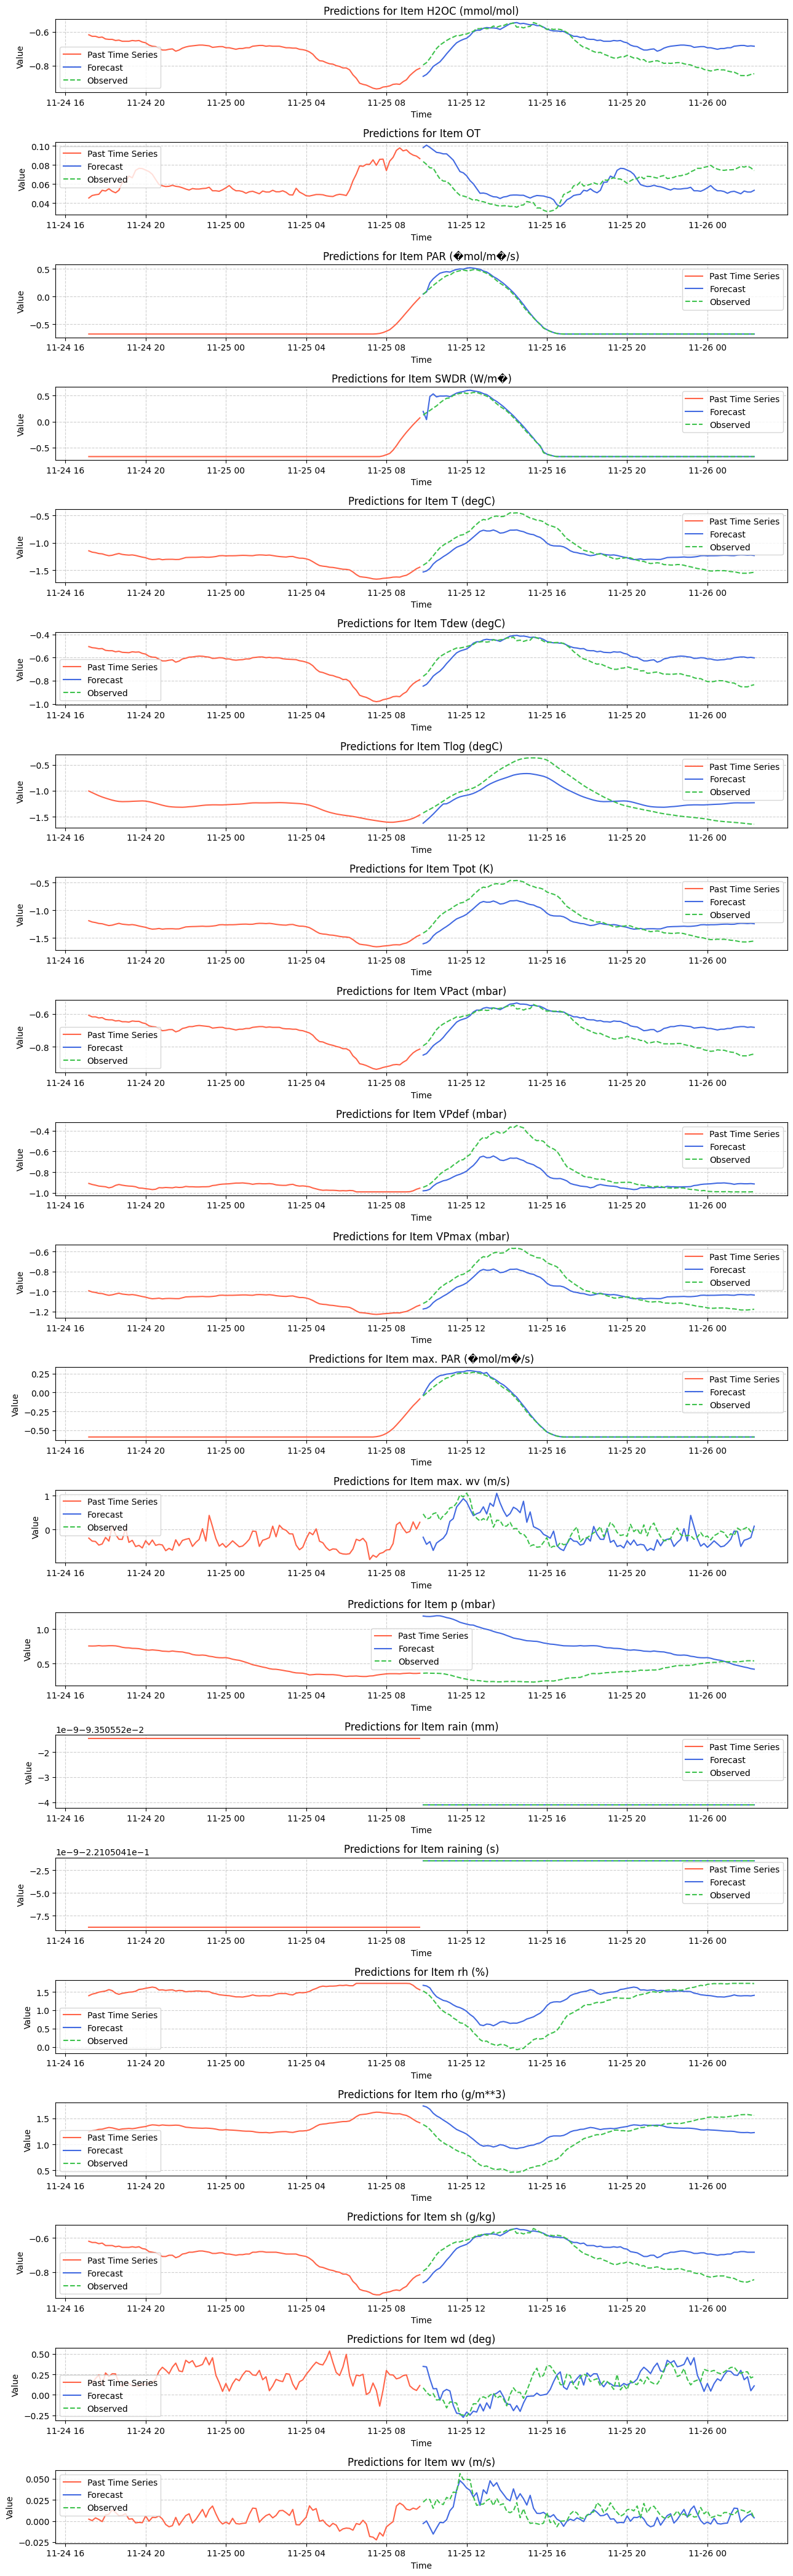

In [ ]:
def plot_timeseries(Y_train_df, predictions, item_ids_to_plot, model_name, intervals, train_index, pred_index, out_of_sample):
    colors = ['#FF6347', '#4169E1', '#3DC24C', '#FF69B4', '#8B008B']

    plt.figure(figsize=(13, 2 * len(item_ids_to_plot)))

    for i, item_id in enumerate(item_ids_to_plot):
        plt.subplot(len(item_ids_to_plot), 1, i + 1)

        y_past = Y_train_df.set_index(['unique_id', 'ds']).loc[item_id]['y']
        y_pred = predictions.loc[item_id]
        y_test = predictions.loc[item_id]['y']

        y_past= y_past[train_index:] if train_index < 0 else y_past[:0]
        y_pred = y_pred[pred_index:] if pred_index < 0 else y_pred[:pred_index]
        y_test = y_test[pred_index:] if pred_index < 0 else y_test[:pred_index]

        plt.plot(y_past, label="Past Time Series", color=colors[0], linestyle='-')
        plt.plot(y_pred[model_name], label="Forecast", color=colors[1], linestyle='-')

        if out_of_sample is not None and not out_of_sample.empty:
            y_out_of_sample = out_of_sample.loc[item_id]
            plt.plot(y_out_of_sample[model_name], label="Out-of-Sample", color=colors[4], linestyle='-')

        plt.plot(y_test, label="Observed", color=colors[2], linestyle='--')
        if intervals:
          plt.fill_between(y_pred.index, y_pred[model_name+"-lo-80"], y_pred[model_name+"-hi-80"], color=colors[1], alpha=0.1, label="10%-90% Test Confidence Interval")

        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title(f"Predictions for Item {item_id}")
        plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


plot_timeseries(Y_train_df, baseline_predictions, item_ids_to_plot=baseline_predictions_df['unique_id'].to_list(), model_name="SeasonalNaive",intervals=False,train_index=-100, pred_index=100, out_of_sample=None)

# TTM

In [ ]:
set_seed(42)
OUT_DIR = "ttm"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 1 # takes value between 0 and 1, this is the ratio of training examples used for fine-tuning later

### Preparing the dataset

In [ ]:
#convert the dataframe to wide-format, this will help preparing the dataset for TTM later.
wide_df = Y_df.pivot(index='ds', columns='unique_id', values='y').reset_index()

wide_df.columns = ['ds'] + [f'y_{col}' for col in wide_df.columns if col != 'ds']
wide_df

,ds,y_H2OC (mmol/mol),y_OT,y_PAR (�mol/m�/s),y_SWDR (W/m�),y_T (degC),y_Tdew (degC),y_Tlog (degC),y_Tpot (K),y_VPact (mbar),...,y_max. PAR (�mol/m�/s),y_max. wv (m/s),y_p (mbar),y_rain (mm),y_raining (s),y_rh (%),y_rho (g/m**3),y_sh (g/kg),y_wd (deg),y_wv (m/s)
0,2020-01-01 00:10:00,-0.999107,0.044395,-0.679493,-0.672767,-1.459980,-1.052596,-1.424132,-1.607935,-0.979132,...,-0.588296,-0.832381,2.114257,-0.093506,-0.22105,0.990128,1.940406,-0.998513,0.555571,-0.017801
1,2020-01-01 00:20:00,-1.008072,0.044134,-0.679493,-0.672767,-1.454798,-1.069612,-1.416612,-1.602882,-0.990506,...,-0.588296,-1.125140,2.099194,-0.093506,-0.22105,0.942141,1.932788,-1.009228,0.354339,-0.029125
2,2020-01-01 00:30:00,-1.012554,0.043092,-0.679493,-0.672767,-1.457389,-1.075800,-1.405331,-1.604145,-0.992781,...,-0.588296,-0.878606,2.087608,-0.093506,-0.22105,0.936809,1.931737,-1.009228,0.242798,-0.025670
3,2020-01-01 00:40:00,-1.026001,0.049343,-0.679493,-0.672767,-1.504031,-1.100551,-1.392796,-1.648356,-1.008704,...,-0.588296,-0.878606,2.085291,-0.093506,-0.22105,1.000792,1.975868,-1.023514,0.349739,-0.016073
4,2020-01-01 00:50:00,-1.014795,0.055073,-0.679493,-0.672767,-1.509213,-1.078894,-1.379008,-1.653408,-0.995055,...,-0.588296,-0.909423,2.081815,-0.093506,-0.22105,1.059442,1.978758,-1.012800,0.386536,-0.027974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52690,2020-12-31 23:20:00,-0.909460,0.057157,-0.679493,-0.672767,-1.256571,-0.970609,-1.179710,-1.105199,-0.929089,...,-0.588296,-0.909423,-1.427746,-0.093506,-0.22105,0.664884,0.731784,-0.909224,0.053065,-0.023367
52691,2020-12-31 23:30:00,-0.873601,0.074346,-0.679493,-0.672767,-1.276005,-0.913372,-1.177203,-1.124146,-0.892694,...,-0.588296,-1.132845,-1.430063,-0.093506,-0.22105,0.830172,0.747283,-0.873508,-0.022829,-0.029125
52692,2020-12-31 23:40:00,-0.900495,0.062886,-0.679493,-0.672767,-1.294143,-0.956686,-1.173443,-1.140567,-0.919990,...,-0.588296,-1.155957,-1.434698,-0.093506,-0.22105,0.782185,0.763569,-0.902081,0.838447,-0.030085
52693,2020-12-31 23:50:00,-0.907219,0.059501,-0.679493,-0.672767,-1.283778,-0.965968,-1.170936,-1.131725,-0.926814,...,-0.588296,-1.036542,-1.434698,-0.093506,-0.22105,0.739530,0.754900,-0.905652,0.237049,-0.026438


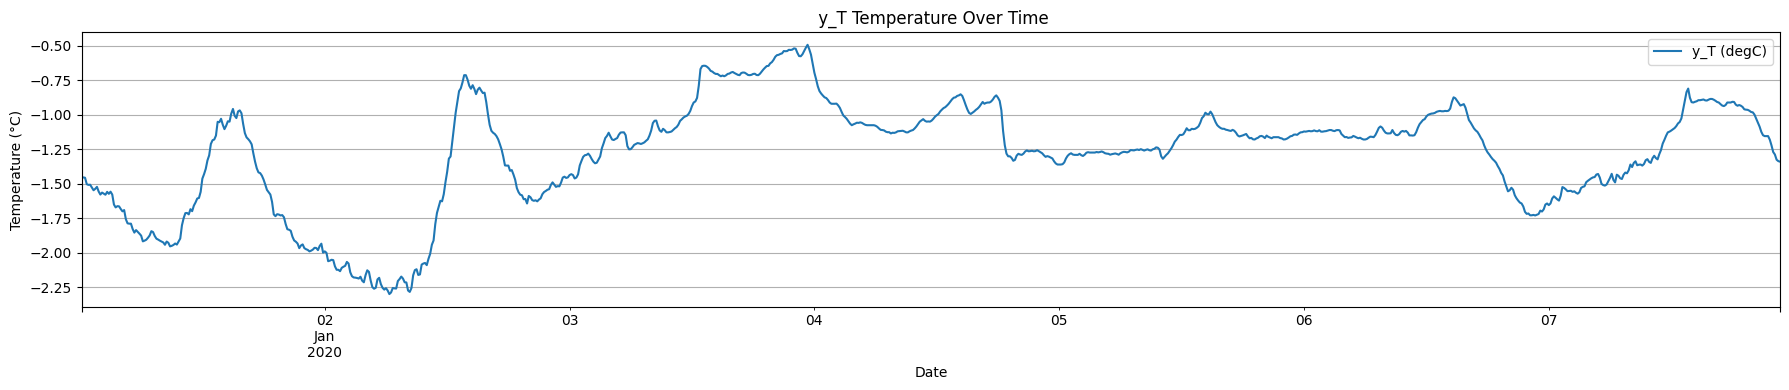

In [ ]:
wide_df.iloc[:1000].plot(x="ds", y="y_T (degC)", figsize=(18,4))
plt.title(' y_T Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')


plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Split the dataset

In [ ]:
#We use the original splits from the Informer paper

from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

timestamp_column = "ds"
id_columns = []
target_columns = [col for col in wide_df.columns if col != 'ds']
split_config = {
                "train": [0, 36886],
                "valid": [36886, 36886 + 10539],
                "test": [
                    36886 + 10539,
                    36886 + 10539 + 5270,
                ],
            }


column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=False,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    wide_df, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 36279, val = 10444, test = 5175


In [ ]:
## let's inspect how those numbers came up

assert(36886 +1 -96 -512 == 36279)  #train_split +1 -horizon -context_length
assert(10539 +1 -96 == 10444) #validation_split +1 -horizon
assert(5270 +1 - 96 == 5175)  #test_split +1 -horizon

## Note: We used fewshot_fraction=1, if less than 1 then multiply with that number

In [ ]:
# the first batch window of the the dataset
train_dataset[0]

{'past_values': tensor([[-0.9991,  0.0444, -0.6795,  ..., -0.9985,  0.5556, -0.0178],
         [-1.0081,  0.0441, -0.6795,  ..., -1.0092,  0.3543, -0.0291],
         [-1.0126,  0.0431, -0.6795,  ..., -1.0092,  0.2428, -0.0257],
         ...,
         [-0.8445,  0.0262, -0.4139,  ..., -0.8449,  0.4785, -0.0013],
         [-0.8445,  0.0256, -0.3454,  ..., -0.8449,  0.6096,  0.0321],
         [-0.8377,  0.0254, -0.3805,  ..., -0.8378,  0.6395,  0.0123]]),
 'future_values': tensor([[-0.8333,  0.0256, -0.3516,  ..., -0.8306,  0.7545,  0.0173],
         [-0.8355,  0.0254, -0.4349,  ..., -0.8342,  0.6131,  0.0511],
         [-0.8310,  0.0254, -0.5727,  ..., -0.8306,  0.6717,  0.0206],
         ...,
         [-0.9812,  0.0233, -0.6795,  ..., -0.9807,  0.8787, -0.0078],
         [-0.9879,  0.0225, -0.6795,  ..., -0.9878,  0.9649, -0.0057],
         [-0.9924,  0.0228, -0.6795,  ..., -0.9914,  1.0983, -0.0119]]),
 'timestamp': numpy.datetime64('2020-01-04T13:20:00.000000000'),
 'id': (0,)}

In [ ]:
 # (context_length, number of unique time-series)
train_dataset[0]['past_values'].shape

torch.Size([512, 21])

In [ ]:
train_dataset[0]['past_values']

tensor([[-0.9991,  0.0444, -0.6795,  ..., -0.9985,  0.5556, -0.0178],
        [-1.0081,  0.0441, -0.6795,  ..., -1.0092,  0.3543, -0.0291],
        [-1.0126,  0.0431, -0.6795,  ..., -1.0092,  0.2428, -0.0257],
        ...,
        [-0.8445,  0.0262, -0.4139,  ..., -0.8449,  0.4785, -0.0013],
        [-0.8445,  0.0256, -0.3454,  ..., -0.8449,  0.6096,  0.0321],
        [-0.8377,  0.0254, -0.3805,  ..., -0.8378,  0.6395,  0.0123]])

In [ ]:
#notice in the second batch here, the training input(window) of each time-series is shifted right
train_dataset[1]['past_values']

tensor([[-1.0081,  0.0441, -0.6795,  ..., -1.0092,  0.3543, -0.0291],
        [-1.0126,  0.0431, -0.6795,  ..., -1.0092,  0.2428, -0.0257],
        [-1.0260,  0.0493, -0.6795,  ..., -1.0235,  0.3497, -0.0161],
        ...,
        [-0.8445,  0.0256, -0.3454,  ..., -0.8449,  0.6096,  0.0321],
        [-0.8377,  0.0254, -0.3805,  ..., -0.8378,  0.6395,  0.0123],
        [-0.8333,  0.0256, -0.3516,  ..., -0.8306,  0.7545,  0.0173]])

In [ ]:
#Notice the similar values of the train_dataset with the observed data (wide_df).

# However, we can notice the similarities because we didn't scale the training data earlier - it wasn't necessary for this dataset.
# Had we scaled the datasets, the values in train_dataset, valid and test would be different.
wide_df.head(4)

,ds,y_H2OC (mmol/mol),y_OT,y_PAR (�mol/m�/s),y_SWDR (W/m�),y_T (degC),y_Tdew (degC),y_Tlog (degC),y_Tpot (K),y_VPact (mbar),...,y_max. PAR (�mol/m�/s),y_max. wv (m/s),y_p (mbar),y_rain (mm),y_raining (s),y_rh (%),y_rho (g/m**3),y_sh (g/kg),y_wd (deg),y_wv (m/s)
0,2020-01-01 00:10:00,-0.999107,0.044395,-0.679493,-0.672767,-1.459980,-1.052596,-1.424132,-1.607935,-0.979132,...,-0.588296,-0.832381,2.114257,-0.093506,-0.22105,0.990128,1.940406,-0.998513,0.555571,-0.017801
1,2020-01-01 00:20:00,-1.008072,0.044134,-0.679493,-0.672767,-1.454798,-1.069612,-1.416612,-1.602882,-0.990506,...,-0.588296,-1.125140,2.099194,-0.093506,-0.22105,0.942141,1.932788,-1.009228,0.354339,-0.029125
2,2020-01-01 00:30:00,-1.012554,0.043092,-0.679493,-0.672767,-1.457389,-1.075800,-1.405331,-1.604145,-0.992781,...,-0.588296,-0.878606,2.087608,-0.093506,-0.22105,0.936809,1.931737,-1.009228,0.242798,-0.025670
3,2020-01-01 00:40:00,-1.026001,0.049343,-0.679493,-0.672767,-1.504031,-1.100551,-1.392796,-1.648356,-1.008704,...,-0.588296,-0.878606,2.085291,-0.093506,-0.22105,1.000792,1.975868,-1.023514,0.349739,-0.016073


## Zero-shot evaluation method

In [ ]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION)
zeroshot_model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

### Getting Predictions

In [ ]:
temp_dir = tempfile.mkdtemp()

zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    )
)

In [ ]:
predictions_test = zeroshot_trainer.predict(test_dataset)
predictions_validation = zeroshot_trainer.predict(valid_dataset)

In [ ]:
#[windows, horizon, number of time-series]
predictions_test[0][0].shape

(5175, 96, 21)

### Validation Loss Evaluation

In [ ]:
zeroshot_trainer.evaluate(valid_dataset)

{'eval_loss': 0.29261887073516846,
 'eval_runtime': 4.8001,
 'eval_samples_per_second': 2175.807,
 'eval_steps_per_second': 34.166}

In [ ]:
# let's make our own evaluation to convince ourselves that evaluate() works as expected:

def long_horizon_mse(dataset, predictions):

    mses = []
    maes = []

    predictions_size = predictions[0][0].shape[0]

    for i in range(predictions_size):
        mse_one_horizon = mse(dataset[i]['future_values'].numpy(), predictions[0][0][i]) #if you use sklearn's mse
        mae_one_horizon = mae(dataset[i]['future_values'].numpy(), predictions[0][0][i]) #if you use sklearn's mae

        #mse_one_horizon = np.mean((dataset[i]['future_values'].numpy() - predictions[0][0][i])**2)
        #mae_one_horizon = np.mean(np.abs(dataset[i]['future_values'].numpy() - predictions[0][0][i]))

        mses.append(mse_one_horizon)
        maes.append(mae_one_horizon)

    data = pd.DataFrame({'mse':[np.array(mses).mean()], 'mae':[np.array(maes).mean()]})

    return data

In [ ]:
# Great, we got the the same MSE!

long_horizon_mse(valid_dataset, predictions_validation)
#0.292619 , 0.254816

,mse,mae
0,0.292619,0.254816


### Test Loss Evaluation

In [ ]:
zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 0.14859862625598907,
 'eval_runtime': 2.4729,
 'eval_samples_per_second': 2092.672,
 'eval_steps_per_second': 32.755}

In [ ]:
long_horizon_mse(test_dataset, predictions_test)
# #0.148599 , 0.177373

,mse,mae
0,0.148599,0.177373


### Visualize predictions

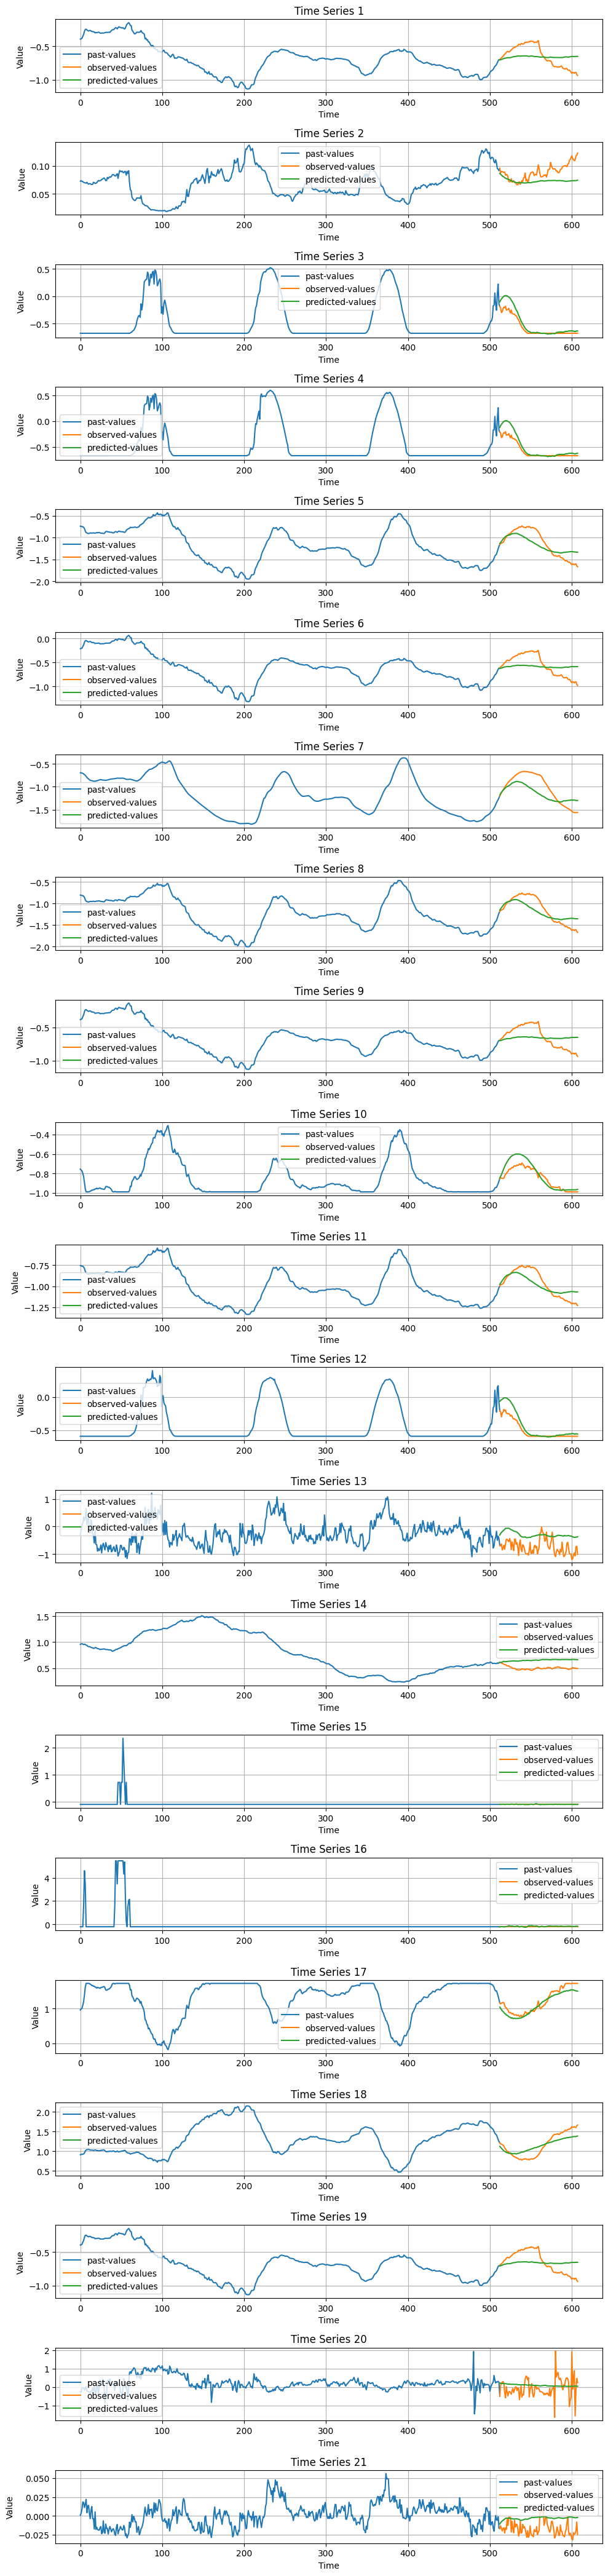

In [ ]:
window = 150

observed_df = pd.DataFrame(torch.cat([test_dataset[window]['past_values'], test_dataset[window]['future_values']]))
predictions_df = pd.DataFrame(predictions_test[0][0][window])
predictions_df.index += 512
predictions_df


plt.figure(figsize=(10, 42))

for i in range(21):
    plt.subplot(21, 1, i + 1)
    plt.plot(observed_df.loc[0:512,i], label="past-values")
    plt.plot(observed_df.loc[512:,i], label="observed-values")
    plt.plot(predictions_df.loc[512:,i], label="predicted-values")

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Time Series {}".format(i+1))
    plt.grid(True)
    plt.tight_layout()

plt.show()

 ## Fine-Tuning

### Load model


In [ ]:
#Note, in case you want to use a shorter prediction_length than 96, e.g. 48
#you can still use the 512-96 TTM model and set prediction_filter_length=48 inside from_pretrained() below

finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION, head_dropout=0.0,dropout=0.0,loss="mse")
finetune_forecast_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.0, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.0, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

### Freeze the TTM backbone

In [ ]:
# Optionally, we can free the backbone layers and fine-tune the rest of the layers
# This increases speed, but comes with some loss of forecasting accuracy

# print("Number of params before freezing backbone",count_parameters(finetune_forecast_model))

# # Freeze the backbone of the model
# for param in finetune_forecast_model.backbone.parameters():
#     param.requires_grad = False

# # Count params
# print("Number of params after freezing the backbone",count_parameters(finetune_forecast_model))

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


### Finetune on train dataset

In [ ]:
learning_rate = 0.001
num_epochs = 40
batch_size = 32

In [ ]:
!rm -r /content/tsfm/ttm/output/

rm: cannot remove '/content/tsfm/ttm_finetuned_models/output/': No such file or directory


In [ ]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.0,
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler)
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss
1,0.471500,0.264779
2,0.380200,0.264261
3,0.366100,0.269462
4,0.351200,0.277813
5,0.336900,0.285322
6,0.325300,0.289977
7,0.314300,0.293856


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: Runtime

[TrackingCallback] Mean Epoch Time = 62.48381338800703 seconds, Total Train Time = 493.019832611084


TrainOutput(global_step=7938, training_loss=0.3636342704851761, metrics={'train_runtime': 493.0325, 'train_samples_per_second': 2943.335, 'train_steps_per_second': 92.002, 'total_flos': 1.319291507294208e+16, 'train_loss': 0.3636342704851761, 'epoch': 7.0})

In [ ]:
predictions_test = finetune_forecast_trainer.predict(test_dataset)
predictions_validation = finetune_forecast_trainer.predict(valid_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
#[window, horizon, number of time-series]
predictions_test[0][0].shape

(5175, 96, 21)

### Validation Loss Evaluation

In [ ]:
finetune_forecast_trainer.evaluate(valid_dataset)

{'eval_loss': 0.26426130533218384,
 'eval_runtime': 8.4028,
 'eval_samples_per_second': 1242.915,
 'eval_steps_per_second': 38.915,
 'epoch': 7.0}

In [ ]:
predictions_validation[0][0].shape[0]

10444

In [ ]:
long_horizon_mse(valid_dataset, predictions_validation)
#0.292619 , 0.254816 (zero-shot)

#0.264261	0.239575 (fine-tuned, this one)

,mse,mae
0,0.264261,0.239575


### Test Set Evaluation

In [ ]:
finetune_forecast_trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 0.1467975676059723,
 'eval_runtime': 5.6915,
 'eval_samples_per_second': 909.257,
 'eval_steps_per_second': 28.464,
 'epoch': 7.0}

In [ ]:
long_horizon_mse(test_dataset, predictions_test)
# #0.148599 , 0.177373 (zero-shot)

#0	0.146798	0.175317  (fine-tuned, this one)

,mse,mae
0,0.146798,0.175317


### Visualize predictions

To benchmark against Seasonal Naive, make sure we compare the same data:

In [ ]:
observed_df = pd.DataFrame(torch.cat([test_dataset[0]['past_values'], test_dataset[0]['future_values']]))
observed_df.loc[512:,0]

512   -0.795160
513   -0.781712
514   -0.757060
515   -0.727924
516   -0.698789
         ...   
603   -0.831018
604   -0.835501
605   -0.837742
606   -0.846707
607   -0.857913
Name: 0, Length: 96, dtype: float32

In [ ]:
baseline_predictions.groupby('unique_id').head(96).head(96)['y']

unique_id        ds                 
H2OC (mmol/mol)  2020-11-25 09:50:00   -0.795160
                 2020-11-25 10:00:00   -0.781712
                 2020-11-25 10:10:00   -0.757060
                 2020-11-25 10:20:00   -0.727924
                 2020-11-25 10:30:00   -0.698789
                                          ...   
                 2020-11-26 01:00:00   -0.831018
                 2020-11-26 01:10:00   -0.835501
                 2020-11-26 01:20:00   -0.837742
                 2020-11-26 01:30:00   -0.846707
                 2020-11-26 01:40:00   -0.857913
Name: y, Length: 96, dtype: float32

In [ ]:
np.allclose(observed_df.loc[512:,0], baseline_predictions.groupby('unique_id').head(96).head(96)['y'])

True

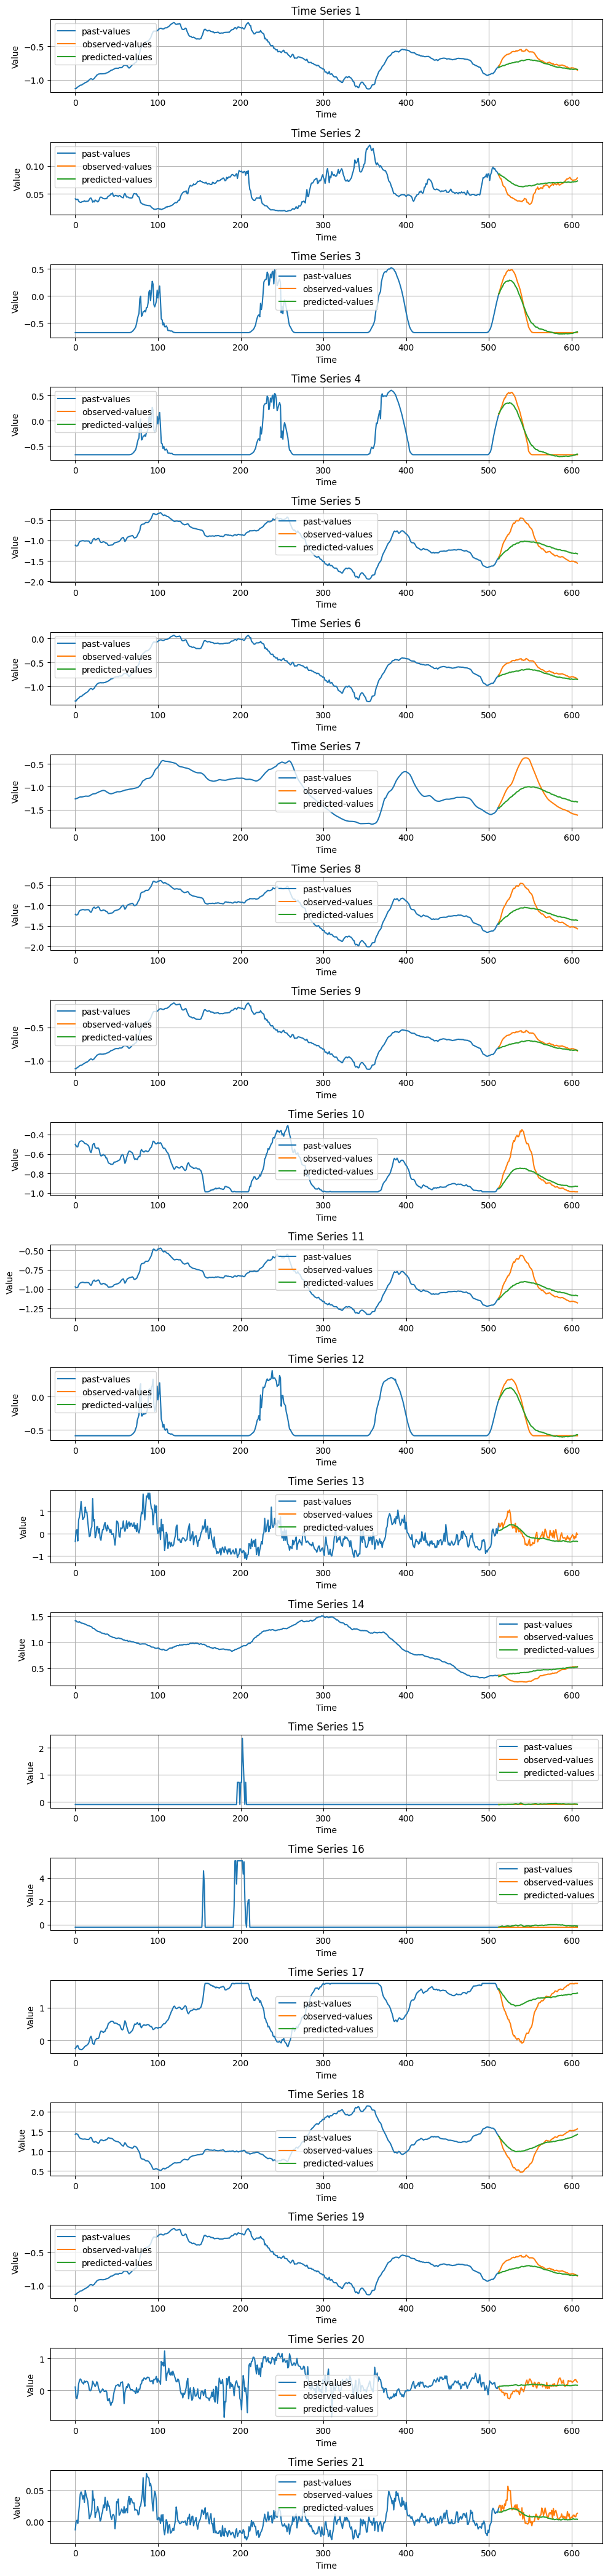

In [ ]:
observed_df = pd.DataFrame(torch.cat([test_dataset[0]['past_values'], test_dataset[0]['future_values']]))
predictions_df = pd.DataFrame(predictions_test[0][0][0])
predictions_df.index += 512
predictions_df

mses_first_horizon = []

plt.figure(figsize=(10, 42))

for i in range(21):
    plt.subplot(21, 1, i + 1)
    plt.plot(observed_df.loc[0:512,i], label="past-values")
    plt.plot(observed_df.loc[512:,i], label="observed-values")
    plt.plot(predictions_df.loc[512:,i], label="predicted-values")

    mse_item_id = np.mean((observed_df.loc[512:,i] - predictions_df.loc[512:,i])**2)
    mses_first_horizon.append(mse_item_id)

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Time Series {}".format(i+1))
    plt.grid(True)
    plt.tight_layout()

plt.show()

In [ ]:
#Seasonal Naive scored an MSE 0.04639

np.mean(mses_first_horizon)

0.045338362

### Save and Reload the Model


Here, we simulate saving the fine-tuned model, deleting it and reloading it again to make sure we recovered the original fine-tuned model correctly:

In [ ]:
finetune_forecast_trainer.model.save_pretrained("best-ttm/model")

In [ ]:
!zip -r ttm_model.zip best-ttm

  adding: best-ttm/ (stored 0%)
  adding: best-ttm/model/ (stored 0%)
  adding: best-ttm/model/config.json (deflated 56%)
  adding: best-ttm/model/model.safetensors (deflated 7%)


In [ ]:
!rm -r best-ttm

In [ ]:
!unzip ttm_model.zip

Archive:  ttm_model.zip
   creating: best-ttm/
   creating: best-ttm/model/
  inflating: best-ttm/model/config.json  
  inflating: best-ttm/model/model.safetensors  


In [ ]:
finetune_forecast_model_new = TinyTimeMixerForPrediction.from_pretrained("best-ttm/model", revision=TTM_MODEL_REVISION, head_dropout=0.0,dropout=0.0)
finetune_forecast_model_new

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.0, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.0, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [ ]:
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True
)

finetune_forecast_trainer_new = Trainer(
    model=finetune_forecast_model_new,
    args=finetune_forecast_args
)

In [ ]:
predictions_test_new = finetune_forecast_trainer_new.predict(test_dataset)
predictions_validation_new = finetune_forecast_trainer_new.predict(valid_dataset)

In [ ]:
finetune_forecast_trainer_new.evaluate(valid_dataset)

{'eval_loss': 0.2642613351345062,
 'eval_runtime': 11.0848,
 'eval_samples_per_second': 942.193,
 'eval_steps_per_second': 117.819}

In [ ]:
long_horizon_mse(valid_dataset, predictions_validation_new)
#0.292619 , 0.254816

#0.264261	0.239575 this

,mse,mae
0,0.264261,0.239575


In [ ]:
finetune_forecast_trainer_new.evaluate(test_dataset)

{'eval_loss': 0.1467975676059723,
 'eval_runtime': 17.9473,
 'eval_samples_per_second': 288.344,
 'eval_steps_per_second': 36.05}

In [ ]:
long_horizon_mse(test_dataset, predictions_test_new)
# #0.148599 , 0.177373

#0	0.146798	0.175317 (this one)

,mse,mae
0,0.146798,0.175317
